<a href="https://colab.research.google.com/github/Bicchie/Skin-Lesions-Classification/blob/main/4_Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Skin Lesions Classifications using pretrained network Inception-v3

## Initialization

In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras import layers
from keras import models
import os
import shutil
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
TRAIN_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/train'
VAL_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/val'
TEST_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/test'
MODELS_PATH = '/content/gdrive/MyDrive/SkinCancer/Models'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/gdrive/MyDrive/SkinCancer/Models/Inception"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

CLASSES = ['Actinic', 'BCC', 'Dermatofibroma', 'Keratosis', 'Melanoma', 'Nevu', 'Vascular']
BATCH_SIZE = 32
RANDOM_SEED = 42
EPOCHS=50
DROPOUT = 0.3

###Dataset Loading

Note that since 450x600 is too large, It is used the interpolation tool in Keras to resize the images in 224x224, also to fit the input of most pretrained networks.

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)

Found 7014 files belonging to 7 classes.
Found 1500 files belonging to 7 classes.
Found 1511 files belonging to 7 classes.


## Utility

In [ ]:
def compile_model(model, metrics='accuracy', loss='sparse_categorical_crossentropy', optimizer='adam', learning_rate = 0.001):
  '''
    compile_model is used to compile the current model
    :param model: model to compile
    :param optimizer: optimizer to be used
    :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    optimizer=optimizers.Adam(learning_rate=learning_rate)
  elif optimizer == 'rmsprop':
    optimizer = optimizers.RMSprop(learning_rate=learning_rate)
  else:
    return

  model.compile(loss=loss,
    optimizer=optimizer,
    metrics=[metrics])

  return model

def run_model (model, model_name, train_ds, val_ds, epochs=50, patience=3, monitor='val_loss', class_weight=None):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + ".h5"

  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience), #we implement EarlyStopping to prevent overfitting
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
           
  history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks_list,
                    class_weight=class_weight
                    )
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  return tf.keras.models.load_model(save_path), history


def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def evaluate_model(model, test_ds):
  test_loss, test_accuracy = model.evaluate(test_ds)
  print("Loss on test set: " +str(test_loss))
  print("Accuracy on test set: " +str(test_accuracy))
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  print(metrics.classification_report(test_labels, test_predictions, target_names=CLASSES, digits=4))

def plot_confusionmatrix(model, test_ds):
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds, verbose=1)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  # plot confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)


def create_class_weight(labels_dict,mu=0.7):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 0.5 else 0.5
    
    return class_weight

# actually compute the CLASS WEIGHTS
labels_dict = {0:327, 1:514, 2:115, 3:1099, 4:1113, 5:6705, 6:142}

class_weight = create_class_weight(labels_dict)

## Feature Extraction



Let's use the Inception-v3 as Feature Extractor.

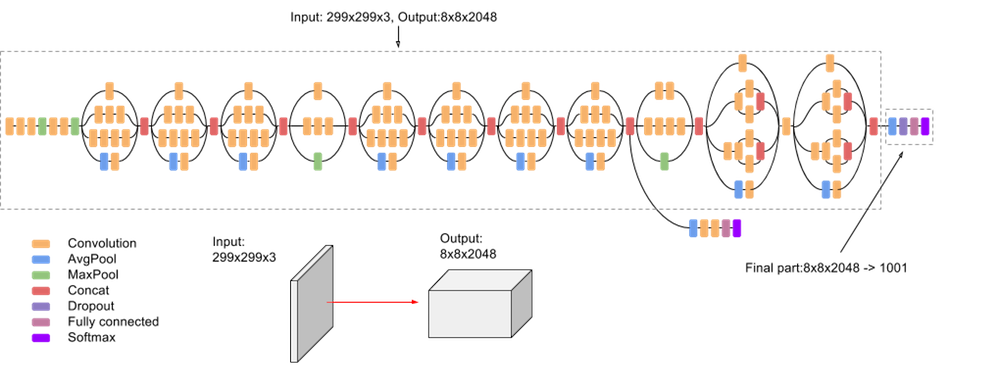

In [ ]:
incept = keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3)
)

incept.trainable = False
incept.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

###Dense

Di qualcosa a riguardo e di perché hai messo il global average pooling

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = incept(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Dense(512,activation='relu', name='classifier_hidden')(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=output, name="Inc")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "Inc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                               

In [ ]:
model, history = run_model(model, "Dense", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 1.5209 - accuracy: 0.6131
Epoch 1: val_loss improved from inf to 0.80508, saving model to /content/models/Dense.h5
220/220 [==============================] - 784s 3s/step - loss: 1.5209 - accuracy: 0.6131 - val_loss: 0.8051 - val_accuracy: 0.7080
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 1.1535 - accuracy: 0.6854
Epoch 2: val_loss did not improve from 0.80508
220/220 [==============================] - 27s 122ms/step - loss: 1.1541 - accuracy: 0.6853 - val_loss: 0.8392 - val_accuracy: 0.6720
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 1.0020 - accuracy: 0.7130
Epoch 3: val_loss did not improve from 0.80508
220/220 [==============================] - 29s 127ms/step - loss: 1.0023 - accuracy: 0.7129 - val_loss: 0.8877 - val_accuracy: 0.6647
Epoch 4/50
219/220 [============================>.] - ETA: 0s - loss: 0.8972 - accuracy: 0.7269
Epoch 4: val_loss improved from 0

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 234s 5s/step - loss: 0.7385 - accuracy: 0.7340
Loss on test set: 0.7385237812995911
Accuracy on test set: 0.7339510321617126
                precision    recall  f1-score   support

       Actinic     0.3014    0.4400    0.3577        50
           BCC     0.4872    0.4750    0.4810        80
Dermatofibroma     0.2857    0.3333    0.3077        18
     Keratosis     0.4848    0.3855    0.4295       166
      Melanoma     0.4608    0.2798    0.3481       168
          Nevu     0.8442    0.9146    0.8780      1007
      Vascular     0.7857    0.5000    0.6111        22

      accuracy                         0.7340      1511
     macro avg     0.5214    0.4755    0.4876      1511
  weighted avg     0.7177    0.7340    0.7209      1511



48/48 [==============================] - 5s 106ms/step


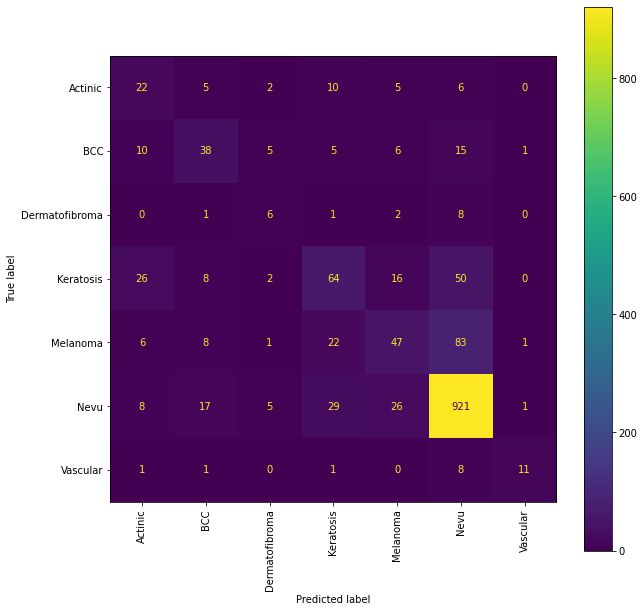

In [ ]:
plot_confusionmatrix(model, test_images)

### Dense Layer and Dropout

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = incept(x)

x = layers.GlobalAveragePooling2D(name='gap')(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(256,activation='relu', name='classifier_hidden')(x)
x = layers.Dropout(DROPOUT)(x)
output = layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output, name="Inc")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "Inc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                               

In [ ]:
model, history = run_model(model, "DenseDropout", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
219/220 [============================>.] - ETA: 0s - loss: 1.6412 - accuracy: 0.5889
Epoch 1: val_loss improved from inf to 0.95974, saving model to /content/models/DenseDropout.h5
220/220 [==============================] - 32s 127ms/step - loss: 1.6418 - accuracy: 0.5890 - val_loss: 0.9597 - val_accuracy: 0.6893
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 1.3676 - accuracy: 0.6398
Epoch 2: val_loss improved from 0.95974 to 0.92948, saving model to /content/models/DenseDropout.h5
220/220 [==============================] - 28s 122ms/step - loss: 1.3675 - accuracy: 0.6396 - val_loss: 0.9295 - val_accuracy: 0.6600
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 1.2215 - accuracy: 0.6658
Epoch 3: val_loss improved from 0.92948 to 0.88056, saving model to /content/models/DenseDropout.h5
220/220 [==============================] - 28s 122ms/step - loss: 1.2219 - accuracy: 0.6658 - val_loss: 0.8806 - val_accuracy: 0.6533
Epoch 4/50
219

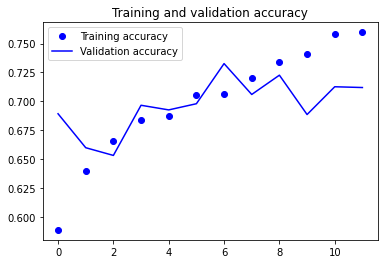

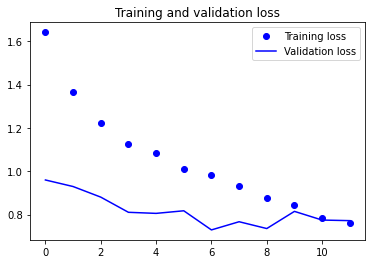

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 6s 101ms/step - loss: 0.7539 - accuracy: 0.7114
Loss on test set: 0.7539419531822205
Accuracy on test set: 0.711449384689331
                precision    recall  f1-score   support

       Actinic     0.3000    0.2400    0.2667        50
           BCC     0.6000    0.4125    0.4889        80
Dermatofibroma     0.2143    0.3333    0.2609        18
     Keratosis     0.4198    0.4096    0.4146       166
      Melanoma     0.3631    0.3869    0.3746       168
          Nevu     0.8623    0.8709    0.8666      1007
      Vascular     0.4667    0.6364    0.5385        22

      accuracy                         0.7114      1511
     macro avg     0.4609    0.4699    0.4587      1511
  weighted avg     0.7122    0.7114    0.7104      1511



48/48 [==============================] - 5s 106ms/step


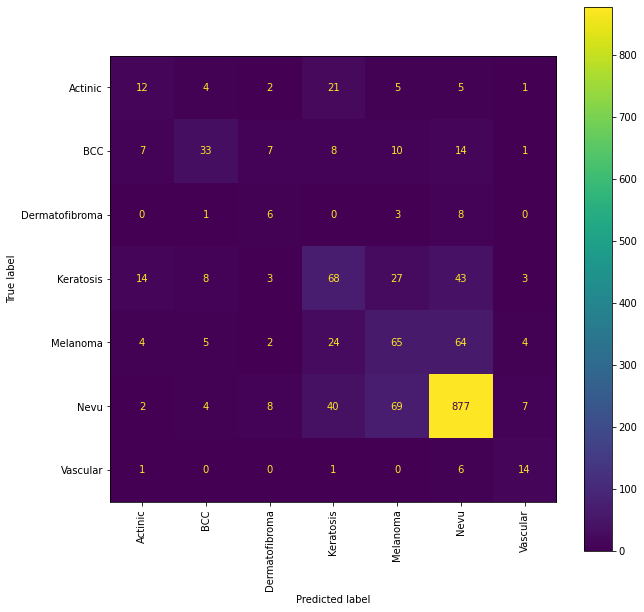

In [ ]:
plot_confusionmatrix(model, test_images)

## Fine Tuning

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/Inception/DenseDropout.h5')

### Last Block

In [ ]:
trainable = False

for layer in model.get_layer('inception_v3').layers:
  if layer.name == 'mixed9':
    trainable = True

  layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)

model.summary()

Model: "Inc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                               

In [ ]:
model, history = run_model(model, "FT_Last1", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 1.0331 - accuracy: 0.7113
Epoch 1: val_loss improved from inf to 0.77854, saving model to /content/models/FT_Last1.h5
220/220 [==============================] - 36s 137ms/step - loss: 1.0331 - accuracy: 0.7113 - val_loss: 0.7785 - val_accuracy: 0.7133
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.5993 - accuracy: 0.8146
Epoch 2: val_loss did not improve from 0.77854
220/220 [==============================] - 28s 124ms/step - loss: 0.5997 - accuracy: 0.8147 - val_loss: 0.7793 - val_accuracy: 0.7167
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.3535 - accuracy: 0.8854
Epoch 3: val_loss did not improve from 0.77854
220/220 [==============================] - 28s 124ms/step - loss: 0.3533 - accuracy: 0.8855 - val_loss: 0.8496 - val_accuracy: 0.7360
Epoch 4/50
219/220 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9271
Epoch 4: val_loss did not im

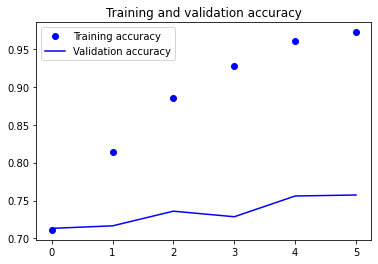

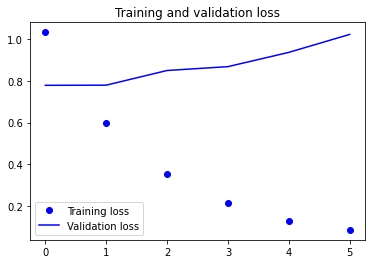

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 5s 101ms/step - loss: 0.9607 - accuracy: 0.7571
Loss on test set: 0.9607092142105103
Accuracy on test set: 0.7571144700050354
                precision    recall  f1-score   support

       Actinic     0.3415    0.2800    0.3077        50
           BCC     0.5769    0.5625    0.5696        80
Dermatofibroma     0.7778    0.3889    0.5185        18
     Keratosis     0.4972    0.5422    0.5187       166
      Melanoma     0.4444    0.4762    0.4598       168
          Nevu     0.8931    0.8878    0.8904      1007
      Vascular     0.6667    0.6364    0.6512        22

      accuracy                         0.7571      1511
     macro avg     0.5997    0.5391    0.5594      1511
  weighted avg     0.7601    0.7571    0.7575      1511



48/48 [==============================] - 5s 103ms/step


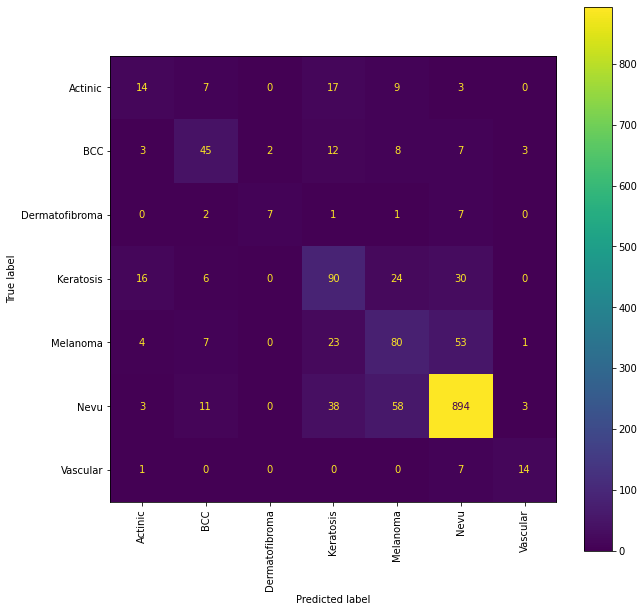

In [ ]:
plot_confusionmatrix(model, test_images)

### Last 2 Blocks

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/Inception/Dense.h5')

In [ ]:
trainable = False

for layer in model.get_layer('inception_v3').layers:
  if layer.name == 'mixed8':
      trainable = True

  layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.0001)

model.summary()

Model: "Inc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                               

In [ ]:
model, history = run_model(model, "FT_Last2", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 1.0766 - accuracy: 0.7083
Epoch 1: val_loss improved from inf to 0.82974, saving model to /content/models/FT_Last2.h5
220/220 [==============================] - 37s 144ms/step - loss: 1.0766 - accuracy: 0.7083 - val_loss: 0.8297 - val_accuracy: 0.6820
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.3415 - accuracy: 0.8854
Epoch 2: val_loss improved from 0.82974 to 0.76300, saving model to /content/models/FT_Last2.h5
220/220 [==============================] - 30s 132ms/step - loss: 0.3415 - accuracy: 0.8854 - val_loss: 0.7630 - val_accuracy: 0.7613
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.1099 - accuracy: 0.9609
Epoch 3: val_loss did not improve from 0.76300
220/220 [==============================] - 29s 128ms/step - loss: 0.1099 - accuracy: 0.9608 - val_loss: 0.8962 - val_accuracy: 0.7627
Epoch 4/50
219/220 [============================>.] - ETA: 0s - loss: 0.055

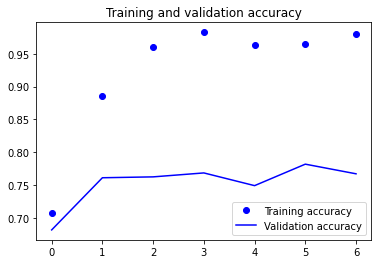

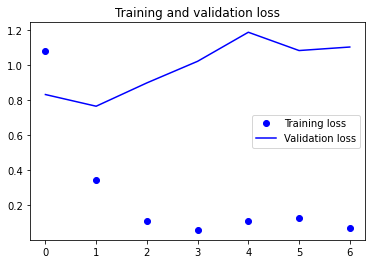

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 7s 102ms/step - loss: 0.8544 - accuracy: 0.7439
Loss on test set: 0.8544040322303772
Accuracy on test set: 0.7438782453536987
                precision    recall  f1-score   support

       Actinic     0.5625    0.1800    0.2727        50
           BCC     0.7778    0.3500    0.4828        80
Dermatofibroma     0.2353    0.2222    0.2286        18
     Keratosis     0.5197    0.4759    0.4969       166
      Melanoma     0.3911    0.5774    0.4663       168
          Nevu     0.8756    0.8878    0.8817      1007
      Vascular     0.6190    0.5909    0.6047        22

      accuracy                         0.7439      1511
     macro avg     0.5687    0.4692    0.4905      1511
  weighted avg     0.7557    0.7439    0.7401      1511



48/48 [==============================] - 5s 104ms/step


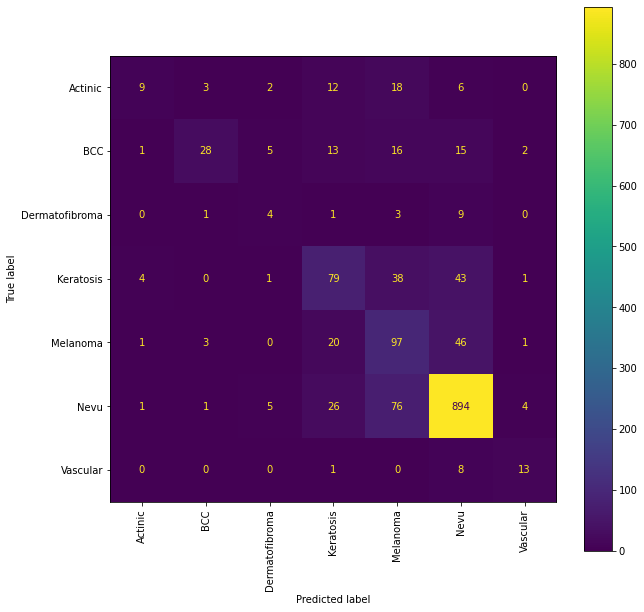

In [ ]:
plot_confusionmatrix(model, test_images)

### Last 3 Blocks

In [ ]:
model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/Inception/DenseDropout.h5')

In [ ]:
trainable = False

for layer in model.get_layer('inception_v3').layers:
  if layer.name == 'mixed7':
      trainable = True

  layer.trainable = trainable

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.00001)

model.summary()

Model: "Inc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                               

In [ ]:
model, history = run_model(model, "FT_Last3", training_images, val_images, EPOCHS, patience=5, monitor='val_loss', class_weight=class_weight)

Epoch 1/50
220/220 [==============================] - ETA: 0s - loss: 1.1718 - accuracy: 0.6744
Epoch 1: val_loss improved from inf to 0.75375, saving model to /content/models/FT_Last3.h5
220/220 [==============================] - 39s 150ms/step - loss: 1.1718 - accuracy: 0.6744 - val_loss: 0.7537 - val_accuracy: 0.7147
Epoch 2/50
219/220 [============================>.] - ETA: 0s - loss: 0.5738 - accuracy: 0.8322
Epoch 2: val_loss improved from 0.75375 to 0.71089, saving model to /content/models/FT_Last3.h5
220/220 [==============================] - 33s 147ms/step - loss: 0.5746 - accuracy: 0.8321 - val_loss: 0.7109 - val_accuracy: 0.7480
Epoch 3/50
219/220 [============================>.] - ETA: 0s - loss: 0.2825 - accuracy: 0.9152
Epoch 3: val_loss did not improve from 0.71089
220/220 [==============================] - 31s 138ms/step - loss: 0.2826 - accuracy: 0.9150 - val_loss: 0.7486 - val_accuracy: 0.7567
Epoch 4/50
219/220 [============================>.] - ETA: 0s - loss: 0.137

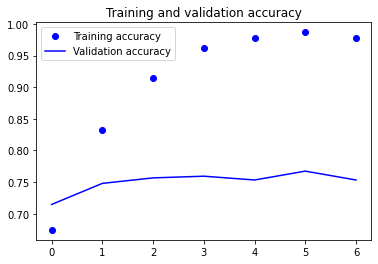

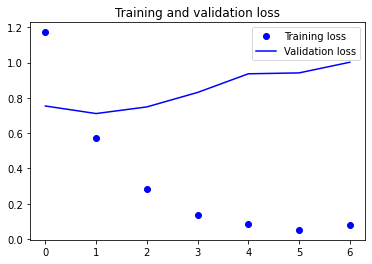

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
evaluate_model(model, test_images)

48/48 [==============================] - 6s 102ms/step - loss: 0.7483 - accuracy: 0.7512
Loss on test set: 0.7483464479446411
Accuracy on test set: 0.7511581778526306
                precision    recall  f1-score   support

       Actinic     0.5000    0.3600    0.4186        50
           BCC     0.6087    0.5250    0.5638        80
Dermatofibroma     0.4000    0.2222    0.2857        18
     Keratosis     0.4972    0.5301    0.5131       166
      Melanoma     0.4197    0.4821    0.4488       168
          Nevu     0.8871    0.8818    0.8845      1007
      Vascular     0.5600    0.6364    0.5957        22

      accuracy                         0.7512      1511
     macro avg     0.5532    0.5197    0.5300      1511
  weighted avg     0.7542    0.7512    0.7515      1511



48/48 [==============================] - 5s 107ms/step


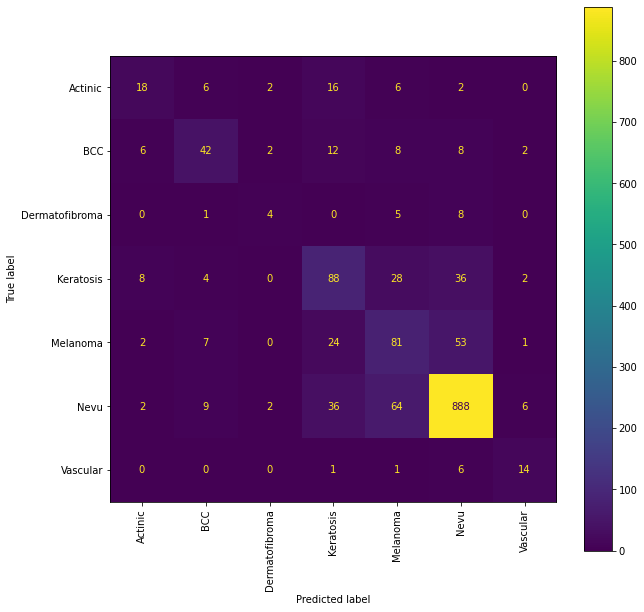

In [ ]:
plot_confusionmatrix(model, test_images)